# Dummy figures
Create small example for paper

Averages:
  1h: 0.5
  0–30 min: 2.0
  30–60 min: -1.0

Energies (kWh):
  import_1min=1.022, export_1min=0.522   Difference:  0.5
  import_30min=1.000, export_30min=0.500   Difference:  0.5
  import_1h=0.500, export_1h=0.000   Difference:  0.5


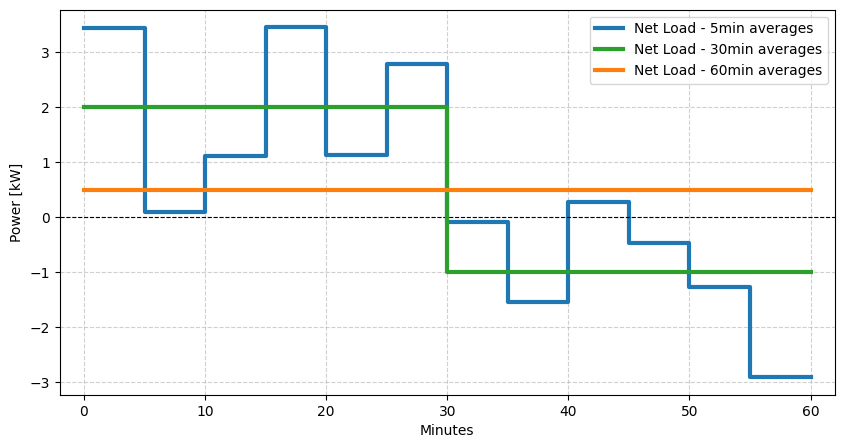

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Time axis: 1h in 5min resolution
periods = 12
time_index = pd.date_range("2025-01-01 12:00", periods=periods, freq="5min")

np.random.seed(42)

def noisy_series(avg, std, size):
    """Generate noise around avg but keep the sample mean exactly = avg."""
    noise = np.random.normal(loc=0.0, scale=std, size=size)
    series = avg + noise
    series += (avg - series.mean())  # recenter
    return series

# --- Build signals ---
# Generation: enforce mean -2.0 in EACH half-hour
half = periods // 2
gen_first  = noisy_series(avg=-2.0, std=1.0, size=half)
gen_second = noisy_series(avg=-2.0, std=1.1, size=periods - half)
gen = np.concatenate([gen_first, gen_second])

# Consumption: 4 kW first half, 1 kW second half (each with exact mean)
cons_first  = noisy_series(avg=4.0, std=1.25, size=half)
cons_second = noisy_series(avg=1.0, std=1.1, size=periods - half)
cons = np.concatenate([cons_first, cons_second])

# Put into DataFrame
df = pd.DataFrame({"Consumption": cons, "Generation": gen}, index=time_index)
df["Prosumption"] = df["Consumption"] + df["Generation"]

# --- Averages ---
avg_pros = round(df["Prosumption"].mean(), 4)
avg_pros_first_half  = round(df["Prosumption"].iloc[:half].mean(), 4)
avg_pros_second_half = round(df["Prosumption"].iloc[half:].mean(), 4)

print("Averages:")
print("  1h:", avg_pros)
print("  0–30 min:", avg_pros_first_half)
print("  30–60 min:", avg_pros_second_half)

# Build 1h and 30min piecewise-constant averages for plotting
df_avg = pd.DataFrame(index=df.index)
df_avg["1h"] = avg_pros
df_avg["30min"] = np.r_[np.full(half, avg_pros_first_half),
                        np.full(len(df) - half, avg_pros_second_half)]

# --- Energies (kWh) computed from time step ---
dt_hours = (df.index[1] - df.index[0]).total_seconds() / 3600.0  # 5/60 = 0.0833 h

pros = df["Prosumption"]
import_1min = (pros.clip(lower=0) * dt_hours).sum()
export_1min = (-pros.clip(upper=0) * dt_hours).sum()

pros_30 = df_avg["30min"]
import_30min = (pros_30.clip(lower=0) * dt_hours).sum()
export_30min = (-pros_30.clip(upper=0) * dt_hours).sum()

pros_1h = df_avg["1h"]
import_1h = (pros_1h.clip(lower=0) * dt_hours).sum()
export_1h = (-pros_1h.clip(upper=0) * dt_hours).sum()

print("\nEnergies (kWh):")
print(f"  import_1min={import_1min:.3f}, export_1min={export_1min:.3f}", "  Difference: ", round(import_1min - export_1min, 4))
print(f"  import_30min={import_30min:.3f}, export_30min={export_30min:.3f}", "  Difference: ", round(import_30min - export_30min, 4))
print(f"  import_1h={import_1h:.3f}, export_1h={export_1h:.3f}", "  Difference: ", round(import_1h - export_1h, 4))

# --- Plot ---
df_plot = df.copy()
# add last point for step plot
step = df_plot.index[1] - df_plot.index[0]
df_plot = pd.concat([df_plot, pd.DataFrame(df_plot.iloc[[-1]], index=[df_plot.index[-1] + step])])

df_avg_plot = df_avg.copy()
df_avg_plot = pd.concat([df_avg, pd.DataFrame(df_avg.iloc[[-1]], index=[df_avg.index[-1] + step])])

# convert index to elapsed minutes since start
minutes_plot = (df_plot.index - df_plot.index[0]).total_seconds() / 60
minutes_avg_plot = (df_avg_plot.index - df_avg_plot.index[0]).total_seconds() / 60

plt.figure(figsize=(10, 5))
plt.step(minutes_plot, df_plot["Prosumption"], label="Net Load - 5min averages", where="post", linewidth=3)
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.step(minutes_avg_plot, df_avg_plot["30min"], label="Net Load - 30min averages", color="tab:green", linestyle="-", linewidth=3, where="post")
plt.step(minutes_avg_plot, df_avg_plot["1h"], label="Net Load - 60min averages", color="tab:orange", linestyle="-", linewidth=3, where="post")

plt.xlabel("Minutes"); plt.ylabel("Power [kW]")
plt.xlim(-2, 62)  # ensure it ends at 60
plt.legend(); plt.grid(True, linestyle="--", alpha=0.6)
#plt.tight_layout()
plt.show()


# plt.figure(figsize=(10, 5))
# plt.step(df.index, df["Prosumption"], label="Prosumption (kW)", where="post")
# plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
# plt.step(df_avg.index, df_avg["1h"], label=f"Avg Prosumption (1h): {avg_pros:.2f} kW", color="tab:orange", linestyle="--", where="post")
# plt.step(df_avg.index, df_avg["30min"], label="Avg Prosumption (30min)", color="tab:green", linestyle="--", where="post")
# plt.title("Synthetic Prosumption (1h, 5min resolution, noisy)")
# plt.xlabel("Time"); plt.ylabel("Power [kW]")
# plt.legend(); plt.grid(True, linestyle="--", alpha=0.6)
# plt.tight_layout(); plt.show()


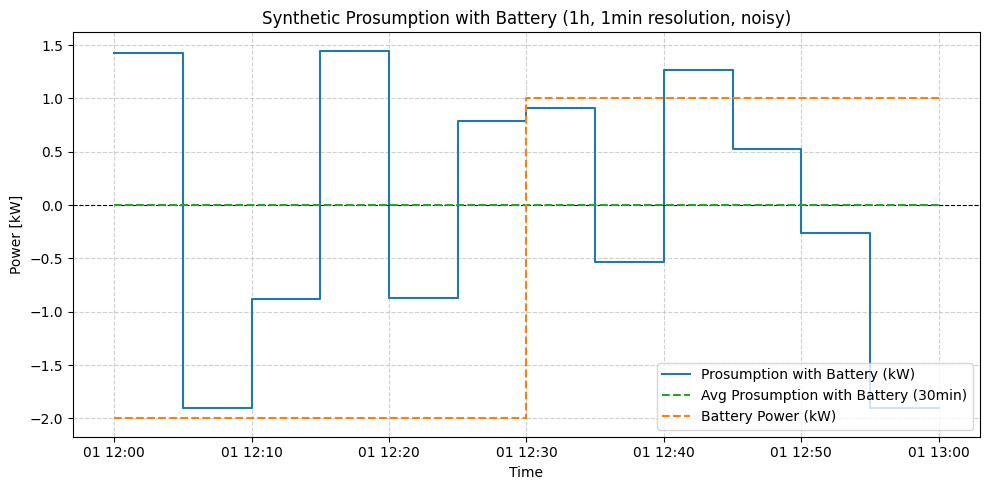

30min with Battery - Imports: 0.1060, Exports: 0.1060
30min with Battery (Avg) - Imports: 0.0000, Exports: -0.0000


In [2]:
# now make an example for the 30min case. Use two battery setpoints to reduce imports/exports. Set it to the df_avg["30min"]
pb_1 = -avg_pros_first_half  # first half battery setpoint
pb_2 = -avg_pros_second_half  # second half battery setpoint

# now calculate the new prosumption with battery setpoints
df['Prosumption_battery'] = df['Prosumption'].copy()
df.loc[df.index[:periods // 2], 'Prosumption_battery'] += pb_1
df.loc[df.index[periods // 2:], 'Prosumption_battery'] += pb_2

df_avg['30min_battery'] = df_avg['30min'].copy()
df_avg.loc[df_avg.index[:periods // 2], '30min_battery'] += pb_1
df_avg.loc[df_avg.index[periods // 2:], '30min_battery'] += pb_2

# get the total amounts of imports and exports for the 30min with battery case
import_30min_battery = df['Prosumption_battery'][df['Prosumption_battery'] > 0].sum() / 60  # kWh
export_30min_battery = -df['Prosumption_battery'][df['Prosumption_battery'] < 0].sum() / 60  # kWh
import_30min_battery_avg = df_avg['30min_battery'][df_avg['30min_battery'] > 0].sum() / 60  # kWh
export_30min_battery_avg = -df_avg['30min_battery'][df_avg['30min_battery'] < 0].sum() / 60  # kWh

# Plot
df_plot = df.copy()
# add last point for step plot
df_plot = pd.concat([df_plot, pd.DataFrame(df_plot.iloc[[-1]], index=[df_plot.index[-1] + (df_plot.index[1] - df_plot.index[0])])])
df_avg_plot = df_avg.copy()
df_avg_plot = pd.concat([df_avg, pd.DataFrame(df_avg.iloc[[-1]], index=[df_avg.index[-1] + (df_avg.index[1] - df_avg.index[0])])])

plt.figure(figsize=(10, 5))
plt.step(df_plot.index, df_plot['Prosumption_battery'], label="Prosumption with Battery (kW)", where='post')
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.step(df_avg_plot.index, df_avg_plot["30min_battery"], label=f"Avg Prosumption with Battery (30min)", color="tab:green", linestyle='--', where='post')

# plot the battery power as well
battery_power = np.concatenate([np.full(periods//2, pb_1), np.full(periods//2, pb_2), [pb_2]]) #
plt.step(df_plot.index, battery_power, label="Battery Power (kW)", color="tab:orange", linestyle='--', where='post')

plt.title("Synthetic Prosumption with Battery (1h, 1min resolution, noisy)")
plt.xlabel("Time")
plt.ylabel("Power [kW]")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

print(f"30min with Battery - Imports: {import_30min_battery:.4f}, Exports: {export_30min_battery:.4f}")
print(f"30min with Battery (Avg) - Imports: {import_30min_battery_avg:.4f}, Exports: {export_30min_battery_avg:.4f}")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# set seed
np.random.seed(42)

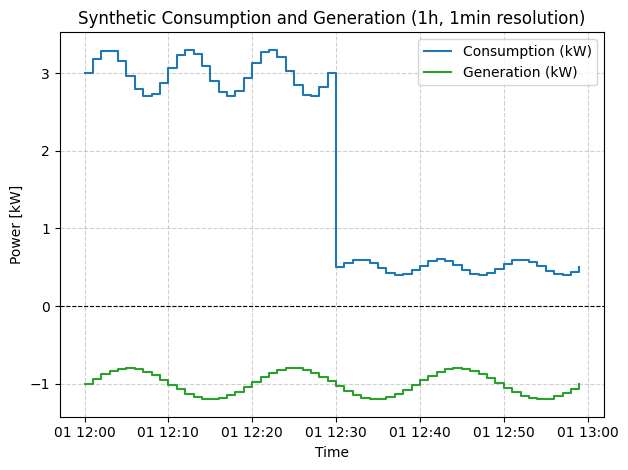

In [4]:
# Time axis: 1h in 1min resolution
time_index = pd.date_range("2025-01-01 12:00", periods=60, freq="1min")

# Generation: oscillate around -1 kW
gen_avg = -1.0
gen = gen_avg + 0.2 * np.sin(np.linspace(0, 6*np.pi, 60))  # oscillation

# Consumption:
# first 30 minutes ~ 3 kW, second 30 minutes ~ 0.5 kW
cons_first = 3.0 + 0.3 * np.sin(np.linspace(0, 6*np.pi, 30))
cons_second = 0.5 + 0.1 * np.sin(np.linspace(0, 6*np.pi, 30))
cons = np.concatenate([cons_first, cons_second])

# Put into DataFrame
df = pd.DataFrame({
    "Consumption": cons,
    "Generation": gen
}, index=time_index)

# Plot
plt.figure() # figsize=(10, 5)
plt.step(df.index, df["Consumption"], label="Consumption (kW)", color="tab:blue", where='post')
plt.step(df.index, df["Generation"], label="Generation (kW)", color="tab:green", where='post')
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")

plt.title("Synthetic Consumption and Generation (1h, 1min resolution)")
plt.xlabel("Time")
plt.ylabel("Power [kW]")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [5]:
def plot_df(df, cols_to_plot):
    # Plot
    plt.figure(figsize=(10, 5))
    for col in cols_to_plot:
        plt.step(df.index, df[col], label=f"{col} (kW)", where='post')
    plt.axhline(0, color="black", linewidth=0.8, linestyle="--")

    plt.title("Synthetic Consumption and Generation (1h, 1min resolution, noisy)")
    plt.xlabel("Time")
    plt.ylabel("Power [kW]")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

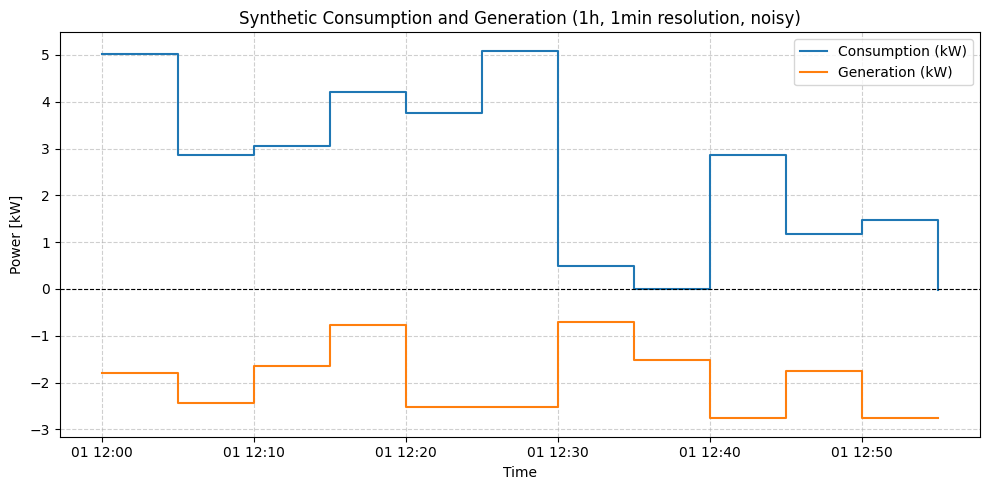

In [6]:
# Time axis: 1h in 1min resolution
periods = 12
#time_index = pd.date_range("2025-01-01 12:00", periods=periods, freq="1min")
time_index = pd.date_range("2025-01-01 12:00", periods=periods, freq="5min")

# Random seed for reproducibility
np.random.seed(42)

def noisy_series(avg, std, size):
    """Generate noise around avg but keep the average unchanged."""
    noise = np.random.normal(loc=0.0, scale=std, size=size)
    series = avg + noise
    # Recenter to keep exact average
    series += (avg - series.mean())
    return series

# Generation: ~ -2 kW
gen = noisy_series(avg=-2.0, std=1.0, size=periods)

# Consumption: first half ~ 4 kW, second half ~ 1 kW
cons_first = noisy_series(avg=4.0, std=1.0, size=periods // 2)
cons_second = noisy_series(avg=1.0, std=1.0, size=periods // 2)
cons = np.concatenate([cons_first, cons_second])

# add last minute to avoid cutting off
#cons = np.append(cons, cons[-1])
#gen = np.append(gen, gen[-1])
#time_index = time_index.append(pd.DatetimeIndex([time_index[-1] + pd.Timedelta(minutes=time_index.freq.n)]))

# Put into DataFrame
df = pd.DataFrame({
    "Consumption": cons,
    "Generation": gen
}, index=time_index)

plot_df(df, ["Consumption", "Generation"])

In [7]:
cons_first.mean()

np.float64(4.0)

In [8]:
print("Mean Generation:", gen.mean())
print("Mean Consumption:", cons.mean())
print("Mean Prosumption:", (cons + gen).mean())



Mean Generation: -2.0
Mean Consumption: 2.4999999999999996
Mean Prosumption: 0.4999999999999997


In [9]:
avg_pros_second_half

np.float64(-1.0)

In [10]:
cons_first.mean() + gen.mean()

np.float64(2.0)

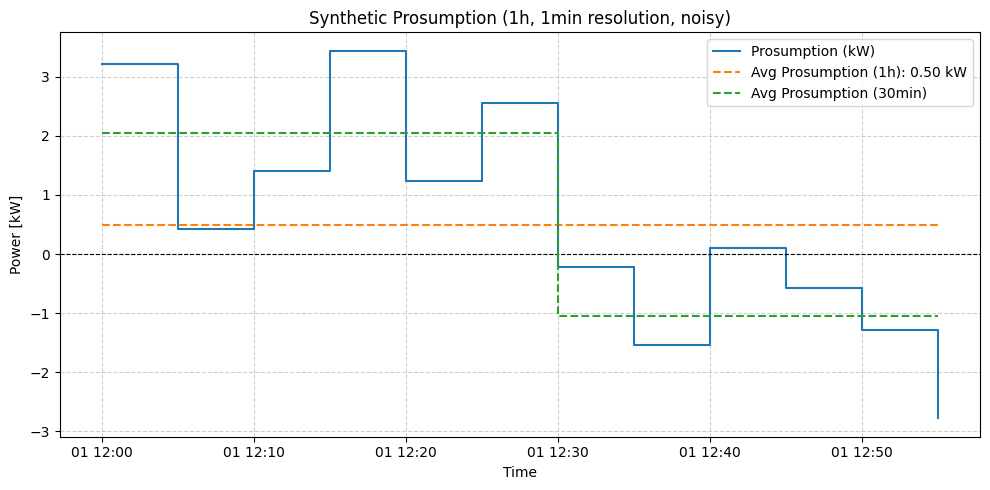

In [11]:
# get sum of consumption and generation
df['Prosumption'] = df['Consumption'] + df['Generation']

avg_pros = df['Prosumption'].mean()
avg_pros_first_half = df['Prosumption'][:periods//2].mean()
avg_pros_second_half = df['Prosumption'][periods//2:].mean()


df_avg = pd.DataFrame({
    "1h": [avg_pros]*len(df)}, index=df.index)
df_avg["30min"] = [avg_pros_first_half] * (len(df) // 2) + [avg_pros_second_half] * (len(df) - len(df) // 2)


# get the total amounts of imports and exports for each case (1min, 30min, 1h)
import_1min = df['Prosumption'][df['Prosumption'] > 0].sum() / 60  # kWh
export_1min = -df['Prosumption'][df['Prosumption'] < 0].sum() / 60  # kWh
import_30min = df_avg['30min'][df_avg['30min'] > 0].sum() / 60  # kWh
export_30min = -df_avg['30min'][df_avg['30min'] < 0].sum() / 60  # kWh
import_1h = df_avg['1h'][df_avg['1h'] > 0].sum() / 60
export_1h = -df_avg['1h'][df_avg['1h'] < 0].sum() / 60



# Plot
plt.figure(figsize=(10, 5))
plt.step(df.index, df['Prosumption'], label="Prosumption (kW)", where='post')
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")

plt.step(df_avg.index, df_avg["1h"], label=f"Avg Prosumption (1h): {avg_pros:.2f} kW", color="tab:orange", linestyle='--', where='post')
plt.step(df_avg.index, df_avg["30min"], label=f"Avg Prosumption (30min)", color="tab:green", linestyle='--', where='post')


plt.title("Synthetic Prosumption (1h, 1min resolution, noisy)")
plt.xlabel("Time")
plt.ylabel("Power [kW]")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
#plot_df(df, ["Prosumption"])

In [12]:
# get the mean of the prosumption of the first and second half
mean_first_half = df['Prosumption'][:periods//2].mean()
mean_first_half

np.float64(2.047524346562304)

In [13]:
print(f"Imports/Exports (kWh):")
print(f"1min - Imports: {import_1min:.4f}, Exports: {export_1min:.4f}", "Difference:", f"{import_1min - export_1min:.4f}")
print(f"30min - Imports: {import_30min:.4f}, Exports: {export_30min:.4f}", "Difference:", f"{import_30min - export_30min:.4f}")
print(f"1h - Imports: {import_1h:.4f}, Exports: {export_1h:.4f}", "Difference:", f"{import_1h - export_1h:.4f}")


Imports/Exports (kWh):
1min - Imports: 0.2065, Exports: 0.1065 Difference: 0.1000
30min - Imports: 0.2048, Exports: 0.1048 Difference: 0.1000
1h - Imports: 0.1000, Exports: -0.0000 Difference: 0.1000


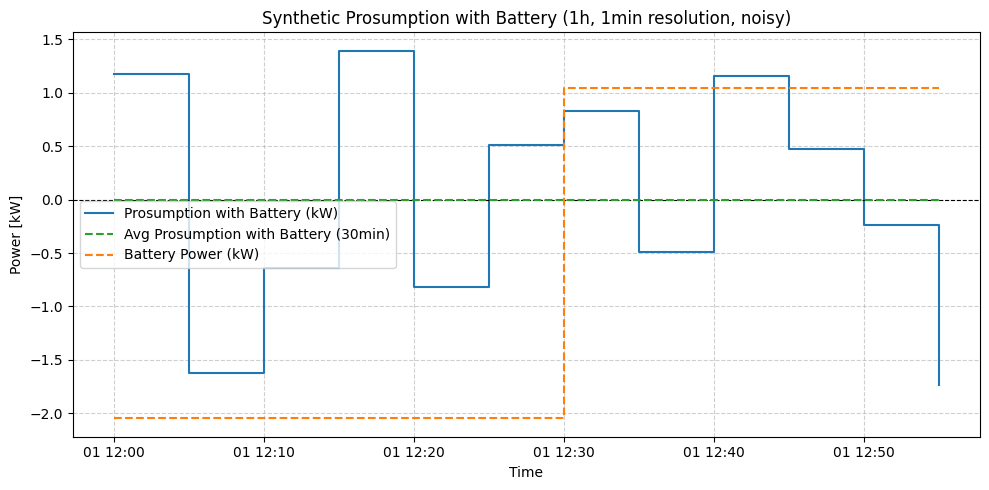

30min with Battery - Imports: 0.09, Exports: 0.09
30min with Battery (Avg) - Imports: 0.00, Exports: -0.00


In [14]:
# now make an example for the 30min case. Use two battery setpoints to reduce imports/exports. Set it to the df_avg["30min"]
pb_1 = -avg_pros_first_half  # first half battery setpoint
pb_2 = -avg_pros_second_half  # second half battery setpoint

# now calculate the new prosumption with battery setpoints
df['Prosumption_battery'] = df['Prosumption'].copy()
df.loc[df.index[:periods // 2], 'Prosumption_battery'] += pb_1
df.loc[df.index[periods // 2:], 'Prosumption_battery'] += pb_2

df_avg['30min_battery'] = df_avg['30min'].copy()
df_avg.loc[df_avg.index[:periods // 2], '30min_battery'] += pb_1
df_avg.loc[df_avg.index[periods // 2:], '30min_battery'] += pb_2

# get the total amounts of imports and exports for the 30min with battery case
import_30min_battery = df['Prosumption_battery'][df['Prosumption_battery'] > 0].sum() / 60  # kWh
export_30min_battery = -df['Prosumption_battery'][df['Prosumption_battery'] < 0].sum() / 60  # kWh
import_30min_battery_avg = df_avg['30min_battery'][df_avg['30min_battery'] > 0].sum() / 60  # kWh
export_30min_battery_avg = -df_avg['30min_battery'][df_avg['30min_battery'] < 0].sum() / 60  # kWh

# Plot
plt.figure(figsize=(10, 5))
plt.step(df.index, df['Prosumption_battery'], label="Prosumption with Battery (kW)", where='post')
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.step(df_avg.index, df_avg["30min_battery"], label=f"Avg Prosumption with Battery (30min)", color="tab:green", linestyle='--', where='post')

# plot the battery power as well
battery_power = np.concatenate([np.full(periods//2, pb_1), np.full(periods//2, pb_2)]) #, [pb_2]
plt.step(df.index, battery_power, label="Battery Power (kW)", color="tab:orange", linestyle='--', where='post')

plt.title("Synthetic Prosumption with Battery (1h, 1min resolution, noisy)")
plt.xlabel("Time")
plt.ylabel("Power [kW]")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

print(f"30min with Battery - Imports: {import_30min_battery:.2f}, Exports: {export_30min_battery:.2f}")
print(f"30min with Battery (Avg) - Imports: {import_30min_battery_avg:.2f}, Exports: {export_30min_battery_avg:.2f}")

In [15]:
df_avg["30min_battery"]

2025-01-01 12:00:00    0.0
2025-01-01 12:05:00    0.0
2025-01-01 12:10:00    0.0
2025-01-01 12:15:00    0.0
2025-01-01 12:20:00    0.0
2025-01-01 12:25:00    0.0
2025-01-01 12:30:00    0.0
2025-01-01 12:35:00    0.0
2025-01-01 12:40:00    0.0
2025-01-01 12:45:00    0.0
2025-01-01 12:50:00    0.0
2025-01-01 12:55:00    0.0
Freq: 5min, Name: 30min_battery, dtype: float64